# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

Figures generated in this script formed the panel shown in Figure 2B.

### Taxonomy distribution of c_AMPs

Here we show the microbial sources of c_AMPs and how they are distributed in the taxonomy levels.

In [1]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def selector(i: tuple):
        '''
        Classify the lowest taxonomical level associated to a given AMP
        '''
        if i[1]['level'].isin(['species']).sum() == 1: return ({i[0]}, 'species')
        if i[1]['level'].isin(['genus']).sum() == 1: return (i[0], 'genus')
        if i[1]['level'].isin(['family']).sum() == 1: return (i[0], 'family')
        if i[1]['level'].isin(['order']).sum() == 1: return (i[0], 'order')
        if i[1]['level'].isin(['class']).sum() == 1: return (i[0], 'class')
        if i[1]['level'].isin(['phylum']).sum() == 1: return (i[0], 'phylum')
        if i[1]['level'].isin(['superkingdom']).sum() == 1: return (i[0], 'superkingdom')

In [3]:
# load data of metagenomic c_AMP genes
data = pd.read_table('../data_folder/complete_amps_associated_taxonomy.tsv.gz', sep='\t', header='infer')

# filter dataframe and drop duplicates
dd = data[['amp', 'level', 'source', 'specI']].drop_duplicates()

# getting annotated AMPs
annotated_amps = dd[~dd['level'].isna()]
annotated_amps = annotated_amps['amp']
annotated_amps = annotated_amps.drop_duplicates()

print(f'# number of AMPs annotated at some level: {len(annotated_amps)}')

# number of AMPs annotated at some level: 752648


In [4]:
# filter AMPs not associated to any origin
ds = (~dd['level'].isna()) & (dd['level'] != 'no rank')
ds = dd[ds]
ds = ds[['amp', 'level']]
ds = ds.drop_duplicates()
ds = ds.sort_values(by=['amp', 'level'])
ds = ds.reset_index(drop=True)

In [5]:
# classify AMPs according lowest known levels   
# and save results as a table
newdf = []
for i in ds.groupby('amp'):
    newdf.append(selector(i))
    
newdf = pd.DataFrame(newdf, columns=['amp', 'taxonomy'])
newdf

,amp,taxonomy
0,{AMP10.000_000},species
1,{AMP10.000_001},species
2,{AMP10.000_002},species
3,{AMP10.000_003},species
4,{AMP10.000_004},species
...,...,...
737569,AMP10.863_483,superkingdom
737570,AMP10.863_488,superkingdom
737571,AMP10.863_493,superkingdom
737572,{AMP10.863_496},species


In [6]:
# organizing taxonomy levels
newdf = newdf['taxonomy'].value_counts()
newdf.loc['none'] = 863_498 - newdf.sum()
newdf = newdf * 100 / newdf.sum()
newdf

species         53.264744
genus           12.767488
family           7.104822
superkingdom     5.628965
class            3.056405
order            2.221314
phylum           1.373252
none            14.583010
Name: taxonomy, dtype: float64

Text(38.097222222222214, 0.5, 'AMPSphere candidates - %')

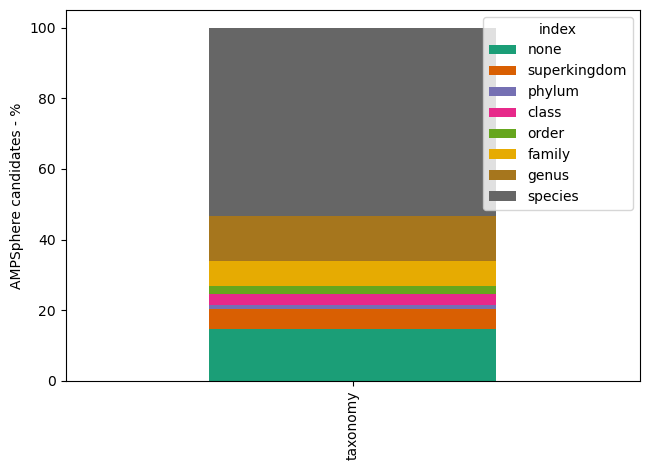

In [7]:
# plot
colsorder = ['none','superkingdom',
             'phylum', 'class',
             'order', 'family',
             'genus', 'species']

pivot = pd.pivot_table(data=newdf.reset_index(),
                       columns='index',
                       values='taxonomy')

pivot = pivot[colsorder]

pivot.plot.bar(stacked=True, cmap='Dark2')
plt.tight_layout()
plt.ylabel('AMPSphere candidates - %')

In [8]:
# select AMPs assigned to genus or species
ds = ds[ds.level.isin(['species', 'genus'])]
ds = ds.groupby('level')['amp'].apply(lambda x: set(x))
selected_group = ds.loc['genus'].union(ds.loc['species'])

# convert dataframe of AMPs with annotated origins
sp = data[(data['amp'].isin(selected_group)) & (data['level'].isin(['species', 'genus']))]
sp = sp[['amp', 'taxid', 'level', 'source']]
sp = sp.sort_values(by=['amp', 'taxid', 'source'])
sp = sp.drop_duplicates()
sp['fixed'] = [x.split(' ')[0] for x in sp.source.values]

In [9]:
sp_next = sp[['amp', 'fixed']].drop_duplicates()
sp_next

,amp,fixed
2764,AMP10.000_000,Bacteroides
0,AMP10.000_000,Phocaeicola
9653,AMP10.000_000,Parabacteroides
2547,AMP10.000_000,Prevotella
3817,AMP10.000_000,Barnesiella
...,...,...
5427587,AMP10.863_461,Georhizobium
5427588,AMP10.863_462,Porticoccus
5427591,AMP10.863_465,MGIIa-L1
5427596,AMP10.863_470,MGIIa-L1


In [10]:
k = sp_next.amp.value_counts()
notunigenus = k[k > 1].index
print(f'The number of AMPs actually associated to more than 1 genus is: {len(notunigenus)}')

The number of AMPs actually associated to more than 1 genus is: 62717


In [11]:
# finding 10 most common genera:
k = sp_next.fixed.value_counts()
k = k.sort_values()
k = k * 100 / 863_498  # percent of AMPSphere
k.tail(10)

Pseudomonas         0.457442
UBA7541             0.457442
CAG-83              0.495195
Oscillibacter       0.522294
Bacteroides         0.552520
CAG-110             0.608455
Faecalibacterium    0.685236
Pelagibacter        0.773019
Bradyrhizobium      1.371862
Prevotella          2.153219
Name: fixed, dtype: float64

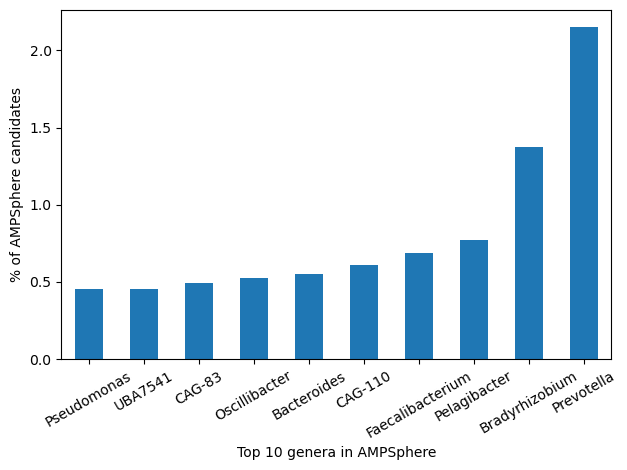

In [12]:
k.tail(10).plot.bar(rot=30, legend=False)
plt.ylabel('% of AMPSphere candidates')
plt.xlabel('Top 10 genera in AMPSphere')
plt.tight_layout()

### Calculate the family taxonomy distribution of c_AMPs

Here we show the families taxnomy assignment and the microbial sources distribution of c_AMP families.

In [13]:
# load data
amp_fam = pd.read_table('../data_folder/SPHERE_v.2022-03.levels_assessment.tsv.gz', sep='\t', header='infer')
amp_fam = amp_fam[['AMP accession', 'SPHERE_fam level III']]
amp_fam = amp_fam.rename({'AMP accession': 'amp',
                          'SPHERE_fam level III': 'family'},
                          axis=1)

In [14]:
# merge families to taxonomy
data = sp_next.merge(on='amp', right=amp_fam)
data = data.sort_values('family')
data = data.drop_duplicates()

In [15]:
# organize taxonomy of families
gen_per_fam = data[['family', 'fixed']]
gen_per_fam = gen_per_fam.drop_duplicates()
gen_per_fam = gen_per_fam['family'].value_counts()
gen_per_fam = gen_per_fam.reset_index()

gen_per_fam.rename({'index': 'family',
                    'family': 'number of genera'},
                  axis=1,
                  inplace=True)

gen_per_fam = gen_per_fam.sort_values(by='number of genera')

gen_per_fam

,family,number of genera
167613,SPHERE-III.409_680,1
223490,SPHERE-III.114_950,1
223489,SPHERE-III.114_948,1
223488,SPHERE-III.114_947,1
223487,SPHERE-III.114_946,1
...,...,...
4,SPHERE-III.000_004,128
3,SPHERE-III.000_040,129
2,SPHERE-III.000_002,144
1,SPHERE-III.000_008,207


In [18]:
# retrieving quality-controlled families
qual = pd.read_table('../data_folder/quality_families.txt.xz', sep='\t', header='infer')

# make sure families have a min size of 8 AMPs
f = (qual.experimental_evidence == True) | (qual.perc >= 75)
qual = qual[f]
qual = qual[(qual.total >= 8)]

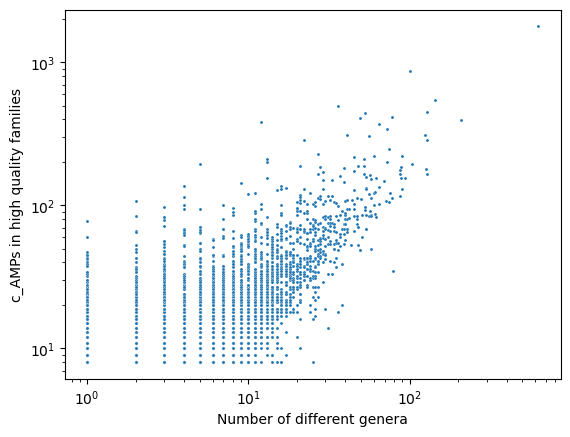

In [19]:
# plot pannel c (big plot)
import seaborn as sns

ndf = gen_per_fam.loc[gen_per_fam.family.isin(qual.family)]

fsize = amp_fam.family.value_counts()
fsize = fsize.reset_index()
fsize = fsize.rename({'index': 'family',
                      'family': 'number of c_AMPs'},
                     axis=1)

ndf = ndf.merge(on='family', right=fsize)

sns.scatterplot(data=ndf, x='number of genera', y='number of c_AMPs', s=5)
plt.ylabel('c_AMPs in high quality families')
plt.xlabel('Number of different genera')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0, 100)

In [20]:
from scipy.stats import spearmanr
spearmanr(ndf['number of genera'],
         ndf['number of c_AMPs'])

SpearmanrResult(correlation=0.5437300425522279, pvalue=0.0)

Text(0, 0.5, 'High quality families')

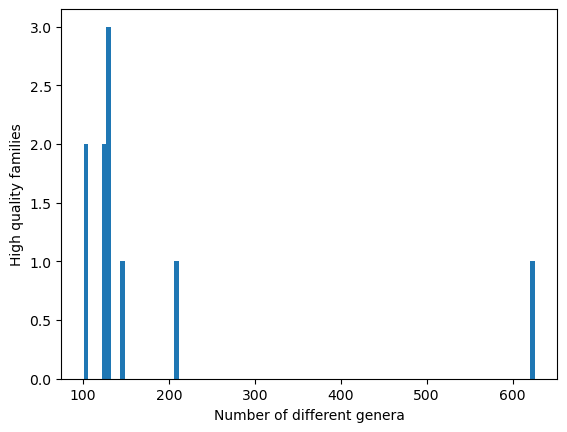

In [21]:
# plot pannel c (detailed plot)
ndf = gen_per_fam.loc[gen_per_fam.family.isin(qual.family)]
ndf = ndf.loc[(ndf['number of genera'] > 100), 'number of genera']
ndf.hist(bins=100, grid=False)
plt.xlabel('Number of different genera')
plt.ylabel('High quality families')

In [22]:
# select quality families affiliating to 
# 1 genus
k = data[['family', 'fixed']].drop_duplicates()
k = k[k.family.isin(qual.family)]
k = k.family.value_counts()
k = k[k == 1].index

In [23]:
# get the number of families specific for each genus
# shows top 10 most represented genera in terms of 
# c_AMPs families
k2 = data[['family', 'fixed']]
k2 = k2[k2.family.isin(k)].drop_duplicates()
k2 = k2.fixed.value_counts()
k2.sort_values().tail(10)

CAG-110             12
Pseudomonas         12
CAG-83              13
Bacteroides         13
Gemmiger            14
Streptococcus       15
Pelagibacter        28
Bradyrhizobium      33
Faecalibacterium    36
Prevotella          57
Name: fixed, dtype: int64